In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import statsmodels as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/juansokoloff/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/juansokoloff/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Import datasets from raw data in github to enssure reproducibility

In [2]:
nrg = pd.read_csv("https://raw.githubusercontent.com/juansokoloff/PUI2017_jss895/master/HW6_jss895/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
nrg.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/juansokoloff/PUI2017_jss895/master/HW6_jss895/MN.csv")

/Users/juansokoloff/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
nrg.columns

Index([u'Record Number', u'BBL', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BI

In [5]:
nrg=nrg[['BBL',"DOF Number of Buildings",'DOF Property Floor Area (Buildngs and Parking)(ft2)', 'Site EUI(kBtu/ft2)', "Reported Property Floor Area (Building(s)) (ft²)"]]

In [6]:
data.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5.0,1018.0,2.0,1.0,10004.0,E007,...,190225.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
1,MN,1,101,101,1.0,1001.0,2.0,1.0,10004.0,E007,...,190636.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
2,MN,1,201,101,1.0,1000.0,2.0,1.0,10004.0,E007,...,193648.0,12b,NaN,199 999,10101.0,NaN,0.0,NaN,1,16V2
3,MN,1,301,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,199 999,10101.0,NaN,0.0,NaN,4,16V2
4,MN,1,401,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,1 99 999,10101.0,NaN,0.0,NaN,4,16V2


# First set of graphs before merging datasets

/Users/juansokoloff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


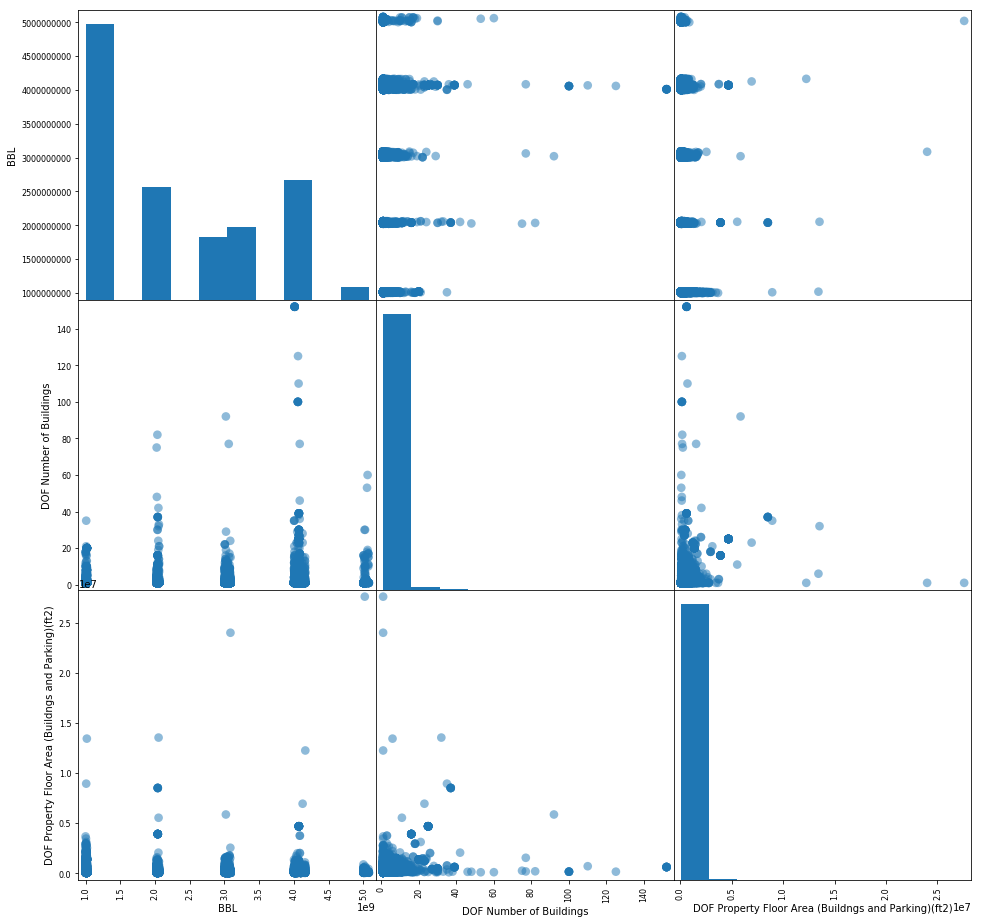

In [7]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));

In [8]:
nrg.rename(columns = {'Site EUI(kBtu/ft2)':"EUI"}, inplace = True)

In [9]:
data.columns

Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'SanitBoro', u'SanitDistrict', u'SanitSub', u'Address',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1',
       u'Overlay2', u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'Easements', u'OwnerType',
       u'OwnerName', u'LotArea', u'BldgArea', u'ComArea', u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'CommFAR', u'

In [10]:
data = data[["UnitsTotal", "BBL"]]

In [11]:
data.head()

,UnitsTotal,BBL
0,0,1.000010e+09
1,0,1.000010e+09
2,0,1.000010e+09
3,0,1.000010e+09
4,0,1.000010e+09


# Making all variables floats in order to be able to work with them

In [12]:
nrg = nrg.apply(lambda x: pd.to_numeric(x, errors = "coerce"))
data = data.apply(lambda x: pd.to_numeric(x, errors = "coerce"))

In [13]:
# use pd.to_numeric to convert strings to numeric values, 
##check that your conversion worked: e.g.
print (nrg['EUI'].astype(float))
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
data.BBL.astype(float)
#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16       125.4
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
         ...  
16140      NaN
16141      NaN
16142      NaN
16143      NaN
16144      NaN
16145      NaN
16146      NaN
16147      NaN
16148      NaN
16149      NaN
16150      NaN
16151      NaN
16152      NaN
16153      NaN
16154      NaN
16155      NaN
16156      NaN
16157      NaN
16158      NaN
16159      NaN
16160      NaN
16161      NaN
16162      NaN
16163      NaN
16164      NaN
16165      NaN
16166      NaN
16167      NaN
16168      NaN
16169      NaN
Name: EUI, Length: 16170, dtype: float64


0        1.000010e+09
1        1.000010e+09
2        1.000010e+09
3        1.000010e+09
4        1.000010e+09
5        1.000020e+09
6        1.000020e+09
7        1.000020e+09
8        1.000020e+09
9        1.000030e+09
10       1.000030e+09
11       1.000030e+09
12       1.000030e+09
13       1.000030e+09
14       1.000048e+09
15       1.000050e+09
16       1.000058e+09
17       1.000060e+09
18       1.000070e+09
19       1.000070e+09
20       1.000070e+09
21       1.000070e+09
22       1.000070e+09
23       1.000070e+09
24       1.000070e+09
25       1.000070e+09
26       1.000070e+09
27       1.000078e+09
28       1.000078e+09
29       1.000080e+09
             ...     
42928    1.022480e+09
42929    1.022480e+09
42930    1.022480e+09
42931    1.022480e+09
42932    1.022480e+09
42933    1.022480e+09
42934    1.022480e+09
42935    1.022480e+09
42936    1.022480e+09
42937    1.022480e+09
42938    1.022488e+09
42939    1.022500e+09
42940    1.022500e+09
42941    1.022500e+09
42942    1

In [14]:
#How many missing values?
indx = np.isnan(nrg['EUI']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 4623


# Merging datasents and making second set of graphs

In [15]:
df = pd.merge(data, nrg, on="BBL")

In [16]:
df.shape

(6536, 6)

/Users/juansokoloff/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


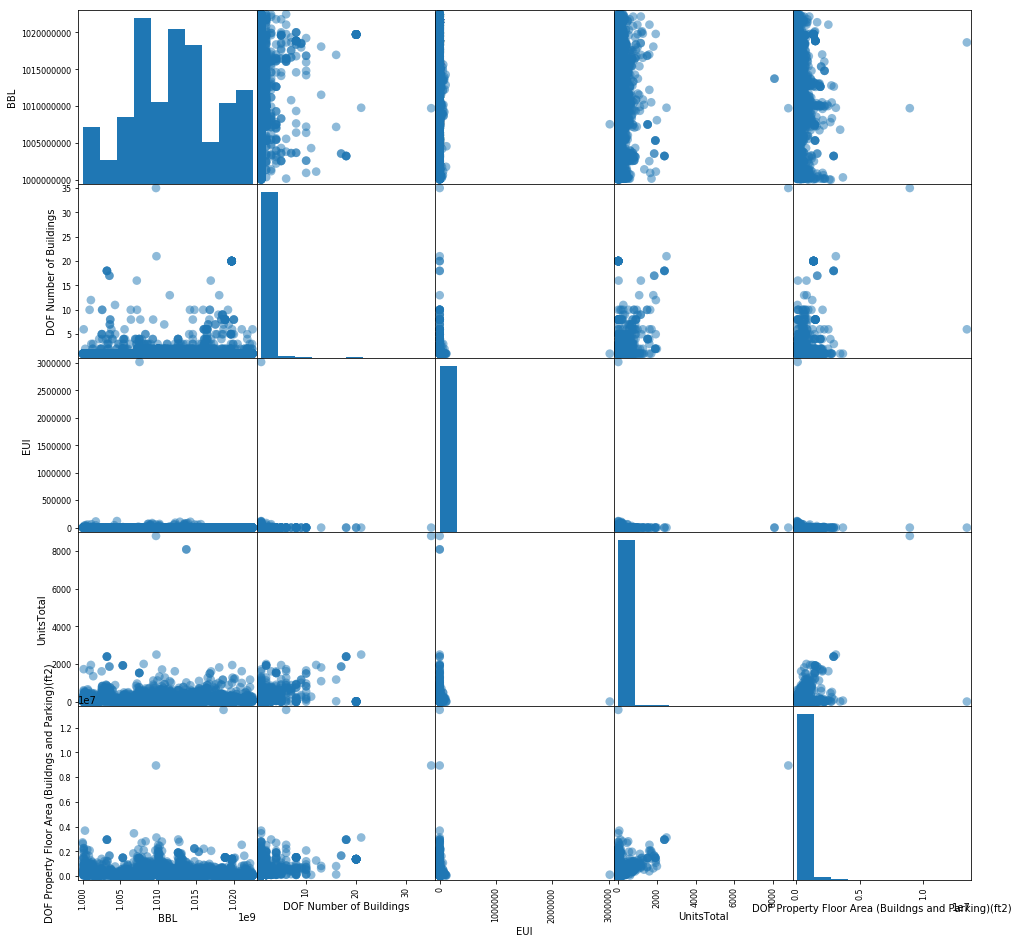

In [17]:
scatter_matrix (df[['BBL',"DOF Number of Buildings", 'EUI', "UnitsTotal", 'DOF Property Floor Area (Buildngs and Parking)(ft2)']], s=300, figsize=(16, 16));

# Starting analysis and graphing Units vs Energy Consumption without applying the logarithm

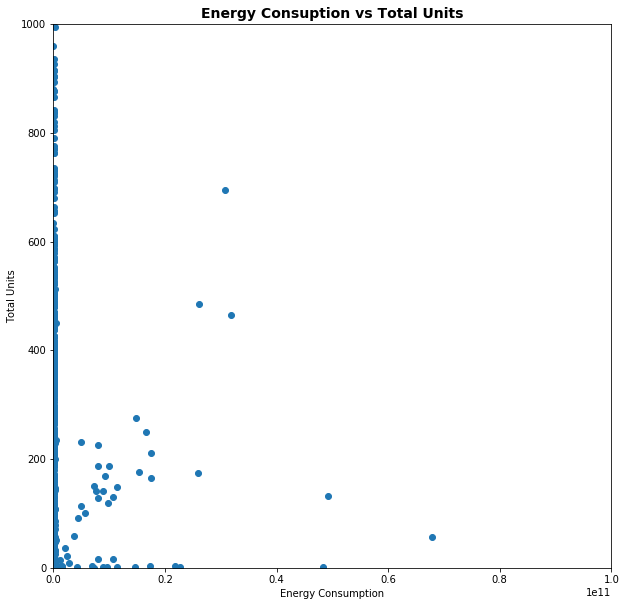

In [18]:
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111)

EnergyConsumption = (df["EUI"] * df["Reported Property Floor Area (Building(s)) (ft²)"])

scatter = ax.scatter(EnergyConsumption, df['UnitsTotal'])
ax.set_xlabel("Energy Consumption")
ax.set_ylabel("Total Units")
ylim((0, 1000))
xlim((0, 100000000000))
plt.title("Energy Consuption vs Total Units", weight='bold', fontsize=14)
plt.show()

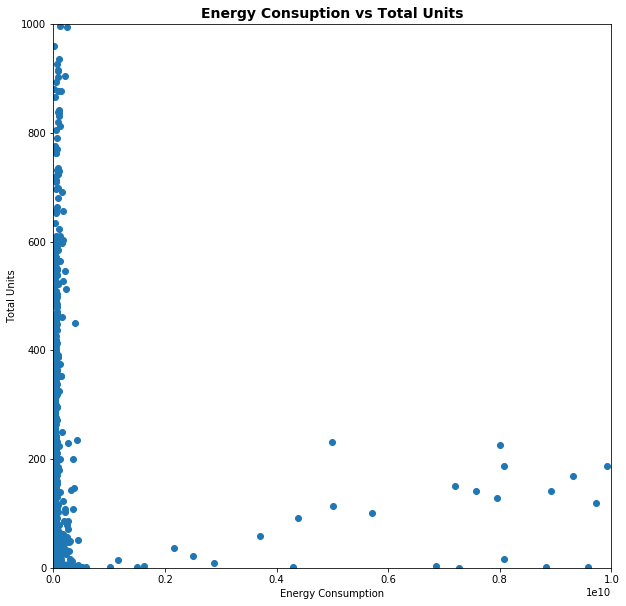

In [19]:
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111)

scatter = ax.scatter(EnergyConsumption, df['UnitsTotal'])
ax.set_xlabel("Energy Consumption")
ax.set_ylabel("Total Units")
ylim((0, 1000))
xlim((0, 10000000000))
plt.title("Energy Consuption vs Total Units", weight='bold', fontsize=14)
plt.show()

In [20]:
df.shape

(6536, 6)

# Graphing implementing the logarithm, (being carefull of not deviding by zero)

/Users/juansokoloff/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


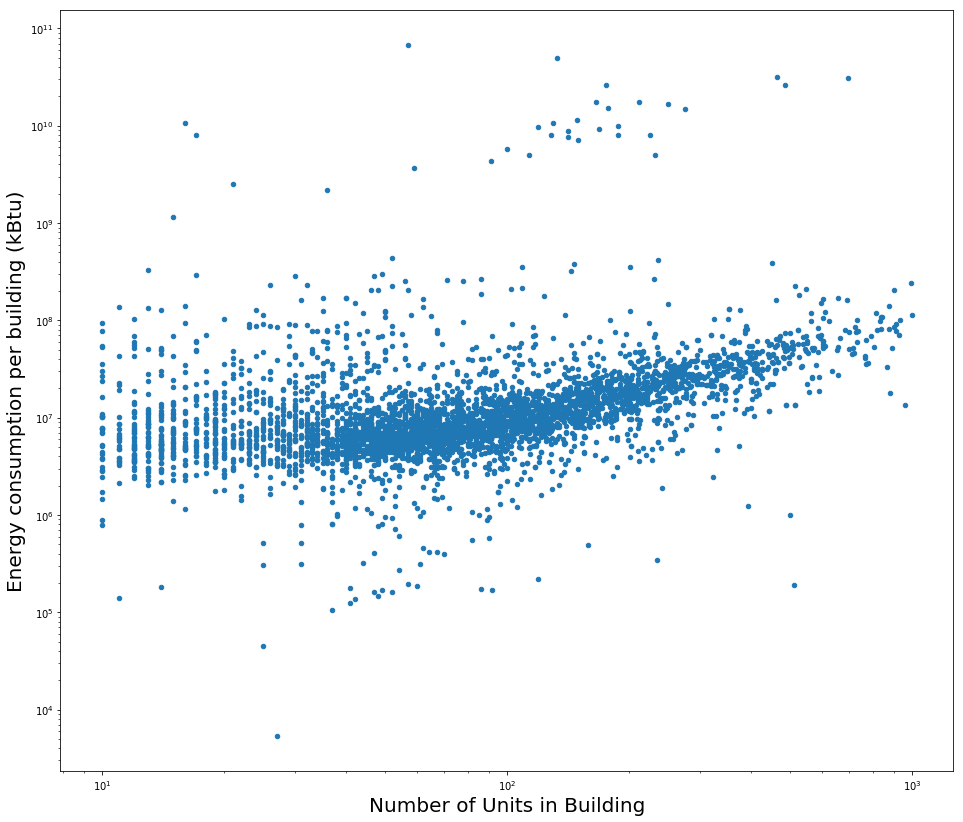

In [21]:
df['EUItotal'] = df["EUI"] * df["Reported Property Floor Area (Building(s)) (ft²)"] 

dfCut = df[(df.EUItotal > 1000) * (df.UnitsTotal>=10) * (df.UnitsTotal<1000)]

ax = dfCut.plot(kind='scatter', y='EUItotal', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

# Running log-log OLS model Energy Consumtion explained by number of units. Plus fitting the line.

In [22]:
y = dfCut["EUItotal"]
x=dfCut['UnitsTotal']
X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit()

In [23]:
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               EUItotal   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.0
Date:                Sun, 22 Oct 2017   Prob (F-statistic):          1.93e-166
Time:                        12:33:30   Log-Likelihood:                -2605.2
No. Observations:                4285   AIC:                             5214.
Df Residuals:                    4283   BIC:                             5227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1089      0.033    186.025      0.000       6.045       6.173
UnitsTotal     0.4904      0.017     28.758      0.000       0.457       0.524
==============================================================================
Omnibus:                     2272.854   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43917.184
Skew:                           2.095   Prob(JB):                         0.00
Kurtosis:                      18.114   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

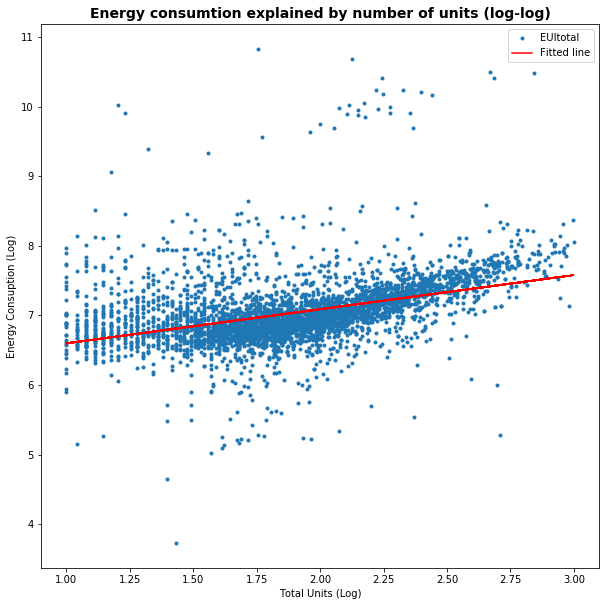

In [33]:
W1 = linmodel.params[1]
W2 = linmodel.params[0] 

dfCut.loc[:,"pred"]=W1*log10(dfCut["UnitsTotal"]) + W2

fig = plt.figure(figsize=(10,10)) 
plt.plot(log10(x), log10(y), ".")
plt.plot(log10(x), dfCut.pred, c="r", label = "Fitted line")
plt.xlabel("Total Units (Log)")
plt.ylabel("Energy Consuption (Log)")
plt.legend()
plt.title("Energy consumtion explained by number of units (log-log)", weight='bold', fontsize=14)

In [25]:
x1 = dfCut["EUItotal"]
y1 = dfCut['UnitsTotal']
X = sm.add_constant(np.log10(x1))
linmodel1 = sm.OLS(np.log10(y1), X, missing='drop').fit()

# Running log-log OLS model Number of Units explained by Energy consumption. Plus fitting the line.

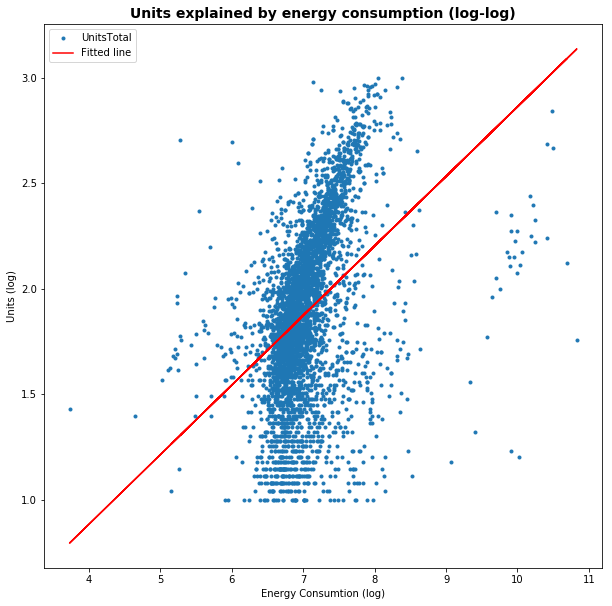

In [34]:
w1 = linmodel1.params[1]
w2 = linmodel1.params[0] 

dfCut.loc[:,"pred1"]=w1*log10(dfCut["EUItotal"]) + w2

fig = plt.figure(figsize=(10,10)) 
plt.plot(log10(x1), log10(y1), ".")
plt.plot(log10(x1), dfCut.pred1, c="r", label = "Fitted line")
plt.xlabel("Energy Consumtion (log)")
plt.ylabel("Units (log)")
plt.legend()
plt.title("Units explained by energy consumption (log-log)", weight='bold', fontsize=14)

In [27]:
#For the units as independent variable
resid_u=np.log10(x) * linmodel.params[1] + linmodel.params[0] - np.log10(y)
error_u=np.sqrt(np.log10(y))

chi_u = ((resid_u ** 2) / error_u).sum()

In [28]:
#For the energy as independent variable
resid_e=np.log10(x1)*linmodel1.params[1]+linmodel1.params[0]-np.log10(y1)
error_e=np.sqrt(np.log10(y1))

chi_e=((resid_e**2)/error_e).sum()

# Running Chi Square test to see which model fits best

In [29]:
print ("The first model has a chi square of",chi_u)
print ("The second model has a chi square of",chi_e)



The first model has a chi square of 305.766392319
The second model has a chi square of 444.023303402


Both models have the same degrees of freedom so they can be compared directly. The first model has a lower chi square, meaning that the distance from the model to the points weighted by the error is smaller than the second model, as such, by the chi square test you can say that the first model is better than the second.

Since the two models are not nested (one does not contain the other, they have the same number of parameters) we cannot compare them with the LR test.


# Making the second degree model and testing if it is better with LR test.

In [30]:
seconddegreemodel=smf.ols(formula="log10(y)~I(log10(x)**2)+log10(x)",data=dfCut).fit()
seconddegreemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log10(y)   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     612.9
Date:                Sun, 22 Oct 2017   Prob (F-statistic):          8.24e-235
Time:                        12:33:31   Log-Likelihood:                -2444.1
No. Observations:                4285   AIC:                             4894.
Df Residuals:                    4282   BIC:                             4913.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.0731      0.112     72.104      0.000       7.854       8.293
I(log10(x) ** 2)     0.5682      0.031     18.288      0.000       0.507       0.629
log10(x)            -1.6706      0.119    -14.003      0.000      -1.905      -1.437
==============================================================================
Omnibus:                     2423.017   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57853.466
Skew:                           2.219   Prob(JB):                         0.00
Kurtosis:                      20.445   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
#using LR to compare both models
print ("LR : ", -2 * (-linmodel.llf - (-seconddegreemodel.llf)))
print ("LR statsmodels:", seconddegreemodel.compare_lr_test(linmodel))

LR :  -322.251327135
LR statsmodels: (322.25132713541097, 4.6829415120305642e-72, 1.0)


With a 322.25 statistic, higher than the rejection value of 3.84 of he Chi Square table with one degree of freedom and 95% confidence you can reject the null hypothesis. As such you reject the null hypothesis that implies no statistical improvement with the more complex model.